In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Scan and detect

Imaging modes such as STEM and ptychography works by scanning an electron probe across a sample and recording the scattering signal. In abTEM, the manner in which the signal is detected is controlled by the detector objects. There is five different types of detectors, each will be described in the following.

## Annular detector
The `AnnularDetector` can be used for simulating the typical modes of STEM, i.e. bright field and annular dark field measurements. The only difference between these are the inner and outer radial integration limits, below we create a detector representing each mode 

In [7]:
from abtem.detect import AnnularDetector

bright = AnnularDetector(inner=.0, outer=.02, extent=10, sampling=.05, energy=200e3)
maadf = AnnularDetector(inner=.05, outer=.086, extent=10, sampling=.05, energy=200e3)
haadf = AnnularDetector(inner=.086, outer=.19, extent=10, sampling=.05, energy=200e3)

As noted in tutorial, abTEM is generally smart enough to infer the grid and energy from context. However, plotting the integration region as below requires us to explicitly set these values.

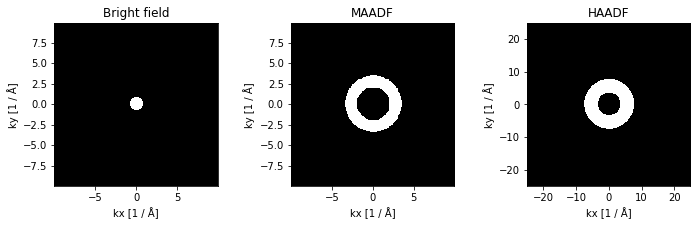

In [53]:
import matplotlib.pyplot as plt

fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(12,3))

bright.get_integration_region().plot(ax=ax1, title='Bright field')
maadf.get_integration_region().plot(ax=ax2, title='MAADF')
haadf.get_integration_region().plot(ax=ax3, title='HAADF');

As noted in an earlier tutorial, the sampling should be fine enough, that the maximum spatial frequency is twice the outer integration limit. Let's fix this by decreasing the pixel size

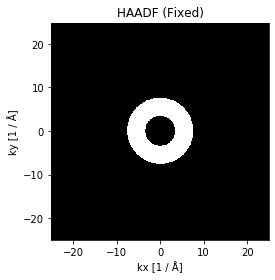

In [51]:
haadf.sampling = .02
haadf.get_integration_region().plot(title='HAADF (Fixed)');

## Segmented detector

The `SegmentedDetector` is partitioned into several integration regions divided at radials and angles. This can be used for simulating for simulating differential phase contrast (DPC) imaging. 

In [55]:
from abtem.detect import SegmentedDetector

segmented_detector = SegmentedDetector(inner = 0, outer=.06, nbins_radial=2, nbins_angular=4, extent=10, sampling=.05, energy=300e3)

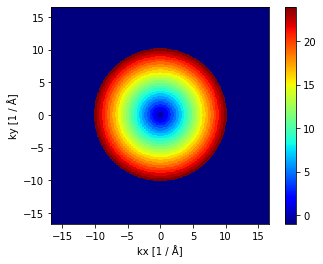

In [59]:
ax, im = segmented_detector.get_integration_region().plot(cmap='jet')

plt.colorbar(im)

Another use of this detector is as a flexible `AnnularDetector`, by choosing a single angular bin and dense sampling of radial bins.

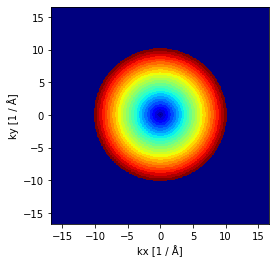

In [57]:
segmented_detector = SegmentedDetector(inner = 0.0, outer=.2, nbins_radial=25, nbins_angular=1, extent=10, sampling=.03, energy=300e3)

segmented_detector.get_integration_region().plot(cmap='jet');

## Pixelated detector

The default use for `PixelatedDetector` object is to save the intensity of the fourier transformed exit wave function, i.e. a complete convergent beam electron diffraction pattern. Hence a 2D scan with this detector results in a large four-dimensional dataset (a 2D diffraction pattern recorded at every 2D probe position). The 4D datasets generated can reconstruct the results of any of the other detector geometries, hence the only downside of using this is the high memory or disk space requirement of storing the data. Optionally this can be mitigated by choosing a downscaling factor or a maximum recorded spatial frequency.

## Custom detector

However,   current   detector   hardware   is   far   from   perfect   with   detectorsexhibiting significant asymmetries or non-uniformities across their active region
The `CustomDetector` allows the user to set the detector efficiency using an array, e.g. representing a measured detector efficiency.